In [1]:
# system imports
import sys
import os
os.environ['DISPLAY'] = '0'
import datetime
import shutil
import atexit
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import matplotlib
if "DISPLAY" not in os.environ:
    matplotlib.use("Agg")

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import dill
from copy import deepcopy
from datetime import timedelta, datetime

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_reflux_distribution,\
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver, disable_restoration
from utility.time_utility import create_filename_time, log_now, log_end

class data_object(object):
    def __init__(self, name):
        self.name = name

2018-10-12 22:09:41 - Start Program


In [2]:
with open('./log/model/Preset_Case_319_pf.pickle','rb') as f:
    model = dill.load(f)
# with open('./log/model/Preset_Case_3_pf.pickle','rb') as f:
#     model = dill.load(f)

In [3]:
opt = add_solver(pe,max_iter=1000,warm_start=True)

In [4]:
model.economic = pe.Var(within=pe.Reals)
model.tunneling_equation = pe.ConstraintList()
model.tunneling_equation.add(model.economic == 
                             43*model.P_total['naphtha']\
                            +20*model.P_total['intermediate']\
                            +90*model.P_total['gasoline']\
                            +128*model.P_total['diesel']\
                            +100*model.P_total['heavy']\
                            +1.3*model.condenser.V['P']\
                            -2.24*model.total_feed\
                            +0.005*(model.N_reflux_tray-1)
);

In [5]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.economic, sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> economic - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [6]:
results = opt.solve(model,tee=False)
update_dual(pe,model)

# We pick the worst of the worst model from our multi-start study

In [7]:
model.economic.value

1.5707742980192814

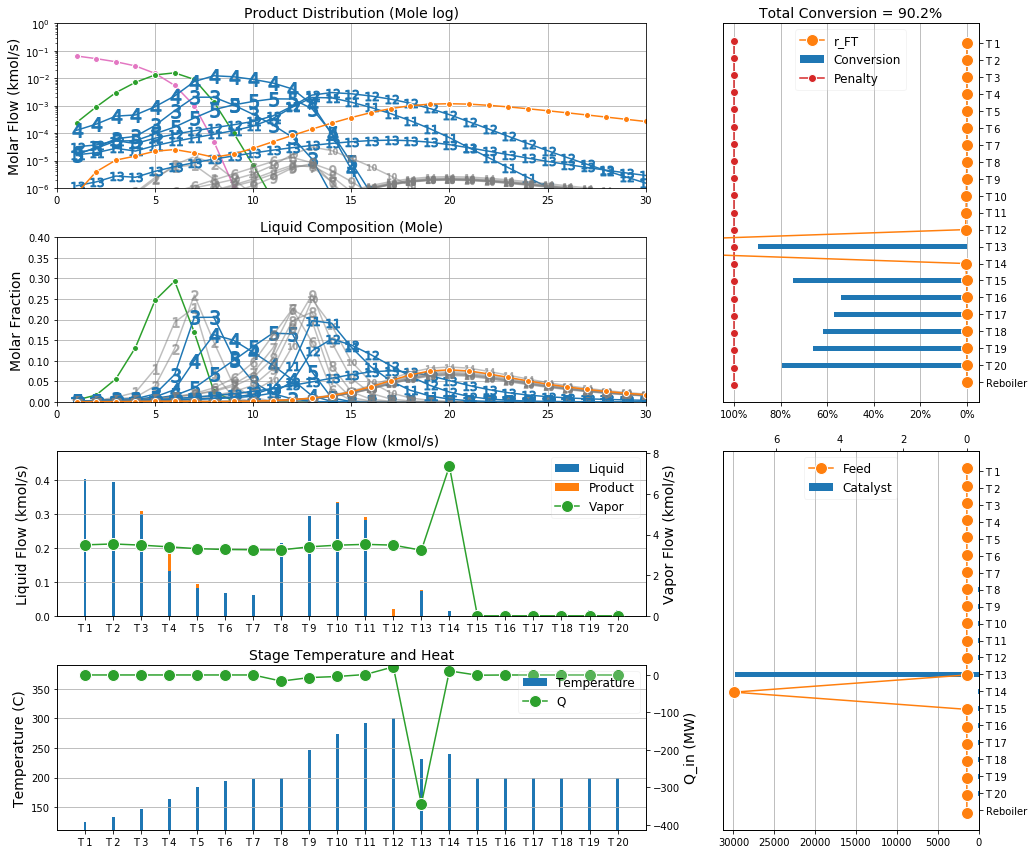

In [8]:
plot_distribution(model)

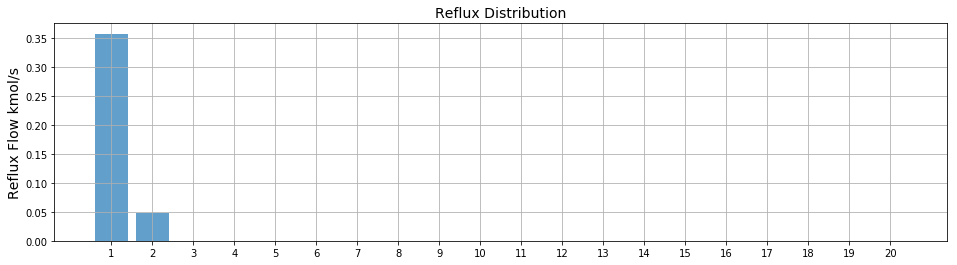

In [9]:
plot_reflux_distribution(model)

# Record its current value and add poles around it

In [10]:
current_solution_extract = {
    'T': {j:model.reactive[j].T.value for j in model.reactive},
    'F': {j:model.reactive[j].F.value for j in model.reactive},
    'cat': {j:model.reactive[j].cat.value for j in model.reactive},
    'economic': model.economic.value
}

In [11]:
model.pole_pf = pe.Var(within=pe.Reals)
model.deviation = pe.Var(within=pe.NonNegativeReals)
model.tunneling_lamb = pe.Param(initialize=1e-4,mutable=True)
model.tunneling_weight = pe.Param(initialize=0.0001,mutable=True)

In [12]:
model.tunneling_equation.add(
    model.deviation <= sum(((model.reactive[j].F - current_solution_extract['F'][j])/(10))**2
                         + ((model.reactive[j].cat - current_solution_extract['cat'][j])/(30000))**2
                         for j in model.reactive)
);

# model.tunneling_equation.add(
#     model.deviation <= sum((model.reactive[j].cat - current_solution_extract['cat'][j])**2
#                            +(model.reactive[j].F - current_solution_extract['F'][j])**2
#                          for j in model.reactive)
# );

model.tunneling_equation.add(
    model.pole_pf  >= model.tunneling_weight / (model.tunneling_lamb + model.deviation)
);

# model.tunneling_equation.add(
#     model.deviation >= model.tunneling_weight
# );



model.tunneling_equation.add(
    model.economic >= current_solution_extract['economic']
);

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.economic - model.pole_pf, sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> economic - pole_pf - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
tol=1e-08
option_file_name=./ipopt.opt
max_iter=1000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           compl_inf_tol = 1                     yes
                         constr_viol_tol = 1                     yes
                            dual_inf_tol = 1000                  yes
                           linear_solver = ma97                  yes
                              ma86_small = 1e-30                  no
                                  ma86_u = 0.0001                 no
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse 

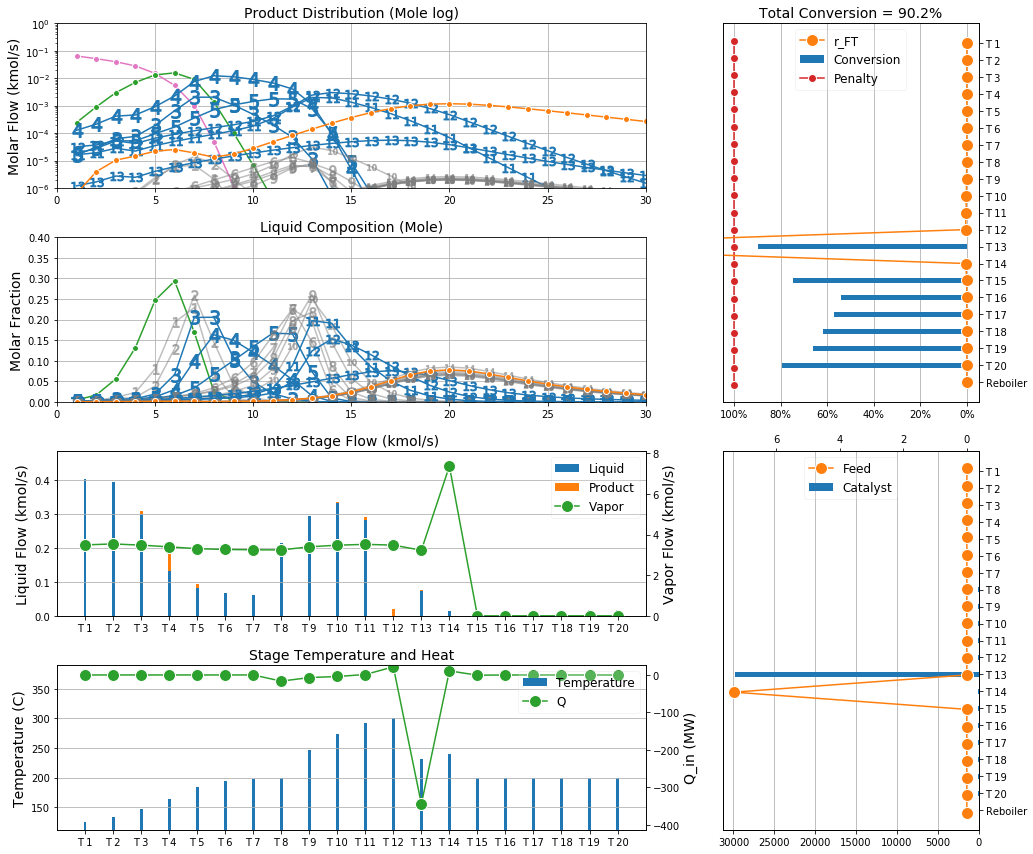

In [15]:
plot_distribution(model)

# Surprise, not much has changed

In [16]:
model.obj()

0.5709002405958961

In [17]:
model.economic.value, current_solution_extract['economic']

(1.570774282313438, 1.5707742980192814)

In [18]:
model.deviation.pprint()

deviation : Size=1, Index=None
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
    None :     0 : 1.2596505674558541e-08 :  None : False : False : NonNegativeReals


In [19]:
for j in model.reactive:
    print('T\t{:.2f}\t{:.2f}\t|\tF\t{:.2f}\t{:.2f}\t|\tcat\t{:.0f}\t{:.0f}'.format(
        model.reactive[j].T.value,current_solution_extract['T'][j],
        model.reactive[j].F.value,current_solution_extract['F'][j],
        model.reactive[j].cat.value,current_solution_extract['cat'][j],))

T	397.20	397.20	|	F	0.00	0.00	|	cat	0	0
T	406.59	406.59	|	F	0.00	0.00	|	cat	0	0
T	419.76	419.76	|	F	0.00	0.00	|	cat	0	0
T	437.39	437.38	|	F	0.00	0.00	|	cat	0	0
T	457.30	457.30	|	F	0.00	0.00	|	cat	0	0
T	467.31	467.31	|	F	0.00	0.00	|	cat	0	0
T	471.20	471.20	|	F	0.00	0.00	|	cat	0	0
T	473.15	473.15	|	F	0.00	0.00	|	cat	10	10
T	519.52	519.53	|	F	0.00	0.00	|	cat	19	19
T	546.90	546.89	|	F	0.00	0.00	|	cat	10	10
T	565.42	565.41	|	F	0.00	0.00	|	cat	10	10
T	573.15	573.15	|	F	0.00	0.00	|	cat	10	10
T	504.61	504.61	|	F	0.00	0.00	|	cat	29844	29844
T	513.24	513.26	|	F	7.32	7.31	|	cat	10	10
T	473.15	473.15	|	F	0.00	0.00	|	cat	16	16
T	473.15	473.15	|	F	0.00	0.00	|	cat	12	12
T	473.15	473.15	|	F	0.00	0.00	|	cat	12	12
T	473.15	473.15	|	F	0.00	0.00	|	cat	13	13
T	473.15	473.15	|	F	0.00	0.00	|	cat	13	13
T	473.15	473.15	|	F	0.00	0.00	|	cat	21	21


# Start the loop to test out successive tunneling

In [21]:
for w in np.linspace(0.0001,1,20):
    
    model.tunneling_weight = w
    
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    
    
    print('\n> w = {}'.format(w))
    for j in model.reactive:
        print('T\t{:.2f}\t{:.2f}\t|\tF\t{:.2f}\t{:.2f}\t|\tcat\t{:.0f}\t{:.0f}'.format(
            model.reactive[j].T.value,current_solution_extract['T'][j],
            model.reactive[j].F.value,current_solution_extract['F'][j],
            model.reactive[j].cat.value,current_solution_extract['cat'][j],))


> w = 0.0001
T	397.20	397.20	|	F	0.00	0.00	|	cat	0	0
T	406.59	406.59	|	F	0.00	0.00	|	cat	0	0
T	419.76	419.76	|	F	0.00	0.00	|	cat	0	0
T	437.39	437.38	|	F	0.00	0.00	|	cat	0	0
T	457.30	457.30	|	F	0.00	0.00	|	cat	0	0
T	467.31	467.31	|	F	0.00	0.00	|	cat	0	0
T	471.20	471.20	|	F	0.00	0.00	|	cat	0	0
T	473.15	473.15	|	F	0.00	0.00	|	cat	10	10
T	519.52	519.53	|	F	0.00	0.00	|	cat	19	19
T	546.90	546.89	|	F	0.00	0.00	|	cat	10	10
T	565.42	565.41	|	F	0.00	0.00	|	cat	10	10
T	573.15	573.15	|	F	0.00	0.00	|	cat	10	10
T	504.61	504.61	|	F	0.00	0.00	|	cat	29844	29844
T	513.24	513.26	|	F	7.32	7.31	|	cat	10	10
T	473.15	473.15	|	F	0.00	0.00	|	cat	16	16
T	473.15	473.15	|	F	0.00	0.00	|	cat	12	12
T	473.15	473.15	|	F	0.00	0.00	|	cat	12	12
T	473.15	473.15	|	F	0.00	0.00	|	cat	13	13
T	473.15	473.15	|	F	0.00	0.00	|	cat	13	13
T	473.15	473.15	|	F	0.00	0.00	|	cat	21	21
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.

> w = 0.05272631578947369
T

ApplicationError: Solver (ipopt) did not exit normally

In [ ]:
model.obj()